In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ffn
import bt

%matplotlib inline

### Create Fake Index Data

In [2]:
mean = np.array([0.05/252 + 0.02/252, 0.03/252 + 0.02/252])
volatility = np.array([0.2/np.sqrt(252), 0.05/np.sqrt(252)])
variance = np.power(volatility,2)
correlation = np.array(
    [
        [1, 0.25],
        [0.25,1]
    ]
)
covariance = np.zeros((2,2))
for i in range(len(variance)):
    for j in range(len(variance)):
        covariance[i,j] = correlation[i,j]*volatility[i]*volatility[j]

covariance

array([[1.58730159e-04, 9.92063492e-06],
       [9.92063492e-06, 9.92063492e-06]])

<AxesSubplot:>

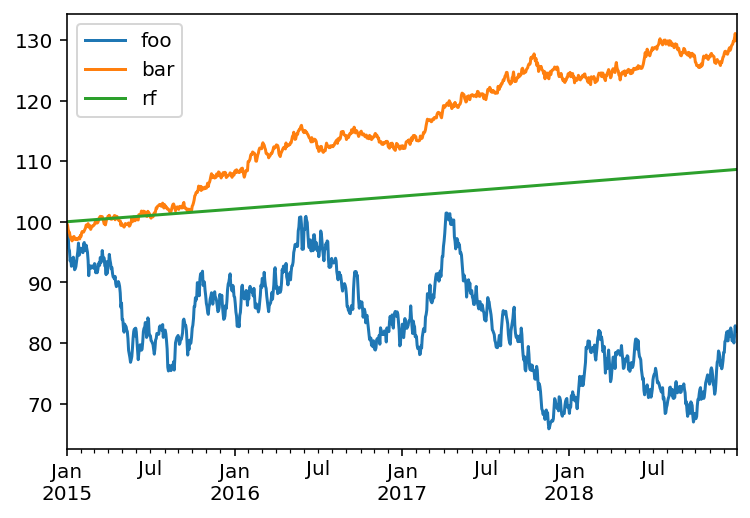

In [3]:
names = ['foo','bar','rf']
dates = pd.date_range(start='2015-01-01',end='2018-12-31', freq=pd.tseries.offsets.BDay())
n = len(dates)
rdf = pd.DataFrame(
    np.zeros((n, len(names))),
    index = dates,
    columns = names
)

np.random.seed(1)
rdf.loc[:,['foo','bar']] = np.random.multivariate_normal(mean,covariance,size=n)
rdf['rf'] = 0.02/252

pdf = 100*np.cumprod(1+rdf)
pdf.plot()

### Build and run ERC Strategy

You can read more about ERC here.
http://thierry-roncalli.com/download/erc.pdf

In [4]:
runAfterDaysAlgo = bt.algos.RunAfterDays(
    20*6 + 1
)

selectTheseAlgo = bt.algos.SelectThese(['foo','bar'])

# algo to set the weights so each asset contributes the same amount of risk
#  with data over the last 6 months excluding yesterday
weighERCAlgo = bt.algos.WeighERC(
    lookback=pd.DateOffset(days=20*6),
    covar_method='standard',
    risk_parity_method='slsqp',
    maximum_iterations=1000,
    tolerance=1e-9,
    lag=pd.DateOffset(days=1)
)

rebalAlgo = bt.algos.Rebalance()

strat = bt.Strategy(
    'ERC',
    [
        runAfterDaysAlgo,
        selectTheseAlgo,
        weighERCAlgo,
        rebalAlgo
    ]
)

backtest = bt.Backtest(
    strat,
    pdf,
    integer_positions=False
)

res_target = bt.run(backtest)

<AxesSubplot:>

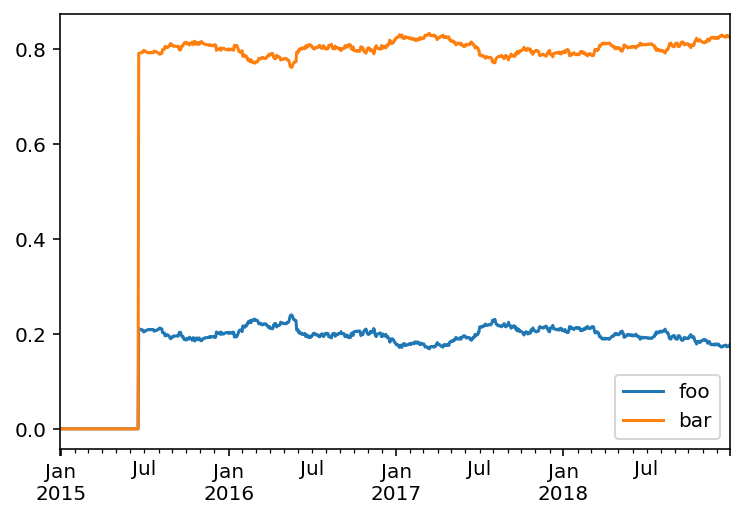

In [5]:
res_target.get_security_weights().plot()

<AxesSubplot:>

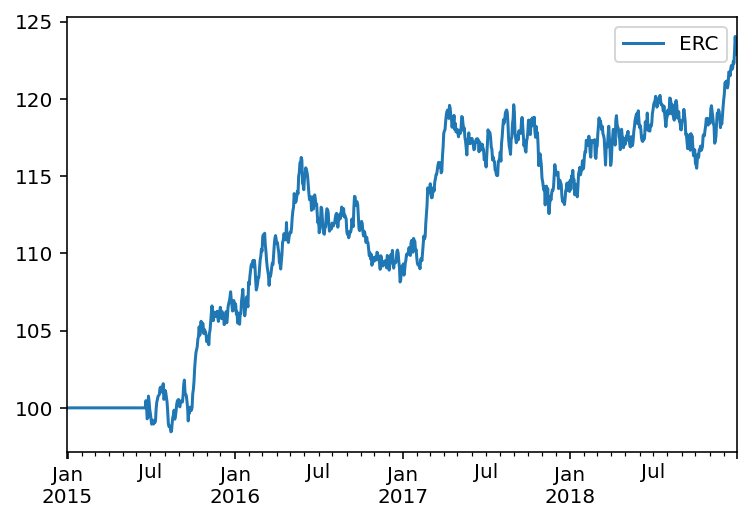

In [6]:
res_target.prices.plot()

[]

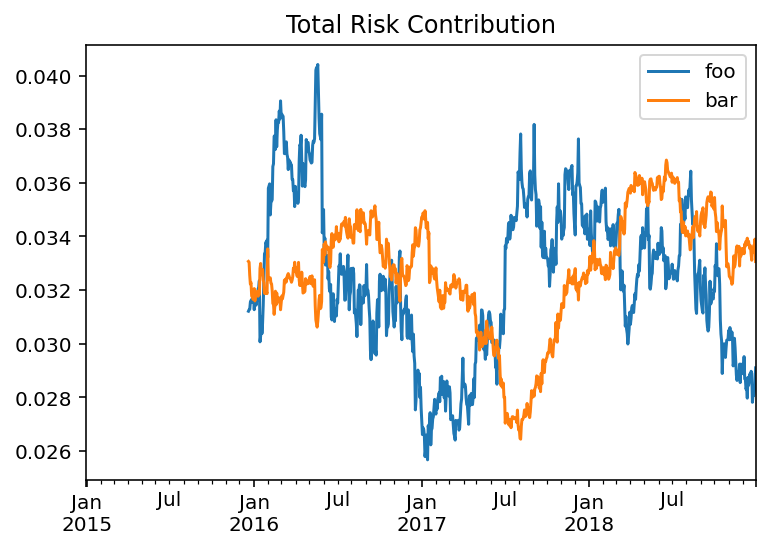

In [9]:
weights_target = res_target.get_security_weights().copy()
rolling_cov_target = pdf.loc[:,weights_target.columns].pct_change().rolling(window=252).cov()*252


trc_target = pd.DataFrame(
    np.nan,
    index = weights_target.index,
    columns = weights_target.columns
)

for dt in pdf.index:
    trc_target.loc[dt,:] = weights_target.loc[dt,:].values*(rolling_cov_target.loc[dt,:].values@weights_target.loc[dt,:].values)/np.sqrt(weights_target.loc[dt,:].values@rolling_cov_target.loc[dt,:].values@weights_target.loc[dt,:].values)


fig, ax = plt.subplots(nrows=1,ncols=1)
trc_target.plot(ax=ax)
ax.set_title('Total Risk Contribution')
ax.plot()


You can see the Total Risk Contribution is roughly equal from both assets.